In [1]:
import numpy as np
import pandas as pd

import sys
import joblib
import datetime
sys.path.append('../')

from Modules.Utils.ModelWrapper import ModelWrapper
from Modules.Models.BuildBINNs import MLPComponentsCVDeep
from Modules.Utils.Imports import *

import Modules.Loaders.DataFormatter as DF
from utils import plot_loss_convergence, get_case_name
import matplotlib
# matplotlib.use('Agg')

c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# helper functions
def to_torch(ndarray):
    arr = torch.tensor(ndarray, dtype=torch.float)
    arr.requires_grad_(True)
    arr = arr.to(device)
    return arr

def to_numpy(x):
    return x.detach().cpu().numpy()

Device set to cpu


In [3]:
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'
population = 50000 # 200000, 100000
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = True
n_runs = 1000
chi_type = 'piecewise'

plot = False
trim = False

case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)

In [4]:
if masking:
    case_name = case_name + '_masking'
    
params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)

In [6]:
data = np.array(params['data'])
data_smooth = np.mean(data, axis=0)
data_smooth = (data_smooth / params['population'])


if trim:
    N = len(data_smooth) - 17
    u = to_torch(data_smooth[16:N+16,:])
else:
    N = len(data_smooth) - 2
    u = to_torch(data_smooth[1:N+1,:])

t_max_real = N
t = np.arange(N)[:,None] + 1
params.pop('data')

tracing_array = params['tracing_array']

In [7]:
# central differences numerical differentiation
if trim:
    u_front = data_smooth[:N+15,:]
    u_back = data_smooth[2:,:]
else:
    u_front = data_smooth[:N,:]
    u_back = data_smooth[2:,:]
    
ut = to_torch((u_back - u_front) / 2.)

In [8]:
# split into train/val and convert to torch
split = int(0.8*N)
# generate shuffled array of indices from 0 to N-1
p = np.random.permutation(N)[:,None]

if trim:
    u_tensor = torch.cat([u[:,:,None], ut[15:,:,None]], axis=2)
else:
    u_tensor = torch.cat([u[:,:,None], ut[:,:,None]], axis=2)

In [9]:
# assign x_train to be randomly shuffled days from 1 to N of size int(0.8 * N)
x_train = to_torch((p[:split] + 1))
# assign y_train to be values corresponding to x_train of size int(0.8 * N)
y_train = to_torch(u[(p[:split]).flatten()])
# assign x_val to be randomly shuffled days from 1 to N of size int(0.2 * N)
x_val = to_torch((p[split:] + 1))
# assign y_val to be values corresponding to y_val of size int(0.2 * N)
y_val = to_torch(u[(p[split:]).flatten()])

C:\Users\Teddy\AppData\Local\Temp\ipykernel_13872\2401209155.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr = torch.tensor(ndarray, dtype=torch.float)


In [10]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (8, 6)

if plot:
    start_idx = 0
    if trim:
        start_idx = 15
    dSdt = ut[start_idx:,0].detach()
    dTdt = ut[start_idx:,1].detach()
    dEdt = ut[start_idx:,2].detach()
    dAdt = ut[start_idx:,3].detach()
    dYdt = ut[start_idx:,4].detach()
    dDdt = ut[start_idx:,5].detach()
    dQdt = ut[start_idx:,6].detach()
    dRdt = ut[start_idx:,7].detach()
    dFdt = ut[start_idx:,8].detach()
    for i in range(9):
        if i==0:
            plt.title('$dSdt$ versus time (days)')
            plt.plot(t, dSdt*population, label='dSdt', color='b')
            plt.xlabel('Time (days)')
            plt.ylabel('$dSdt$')
            plt.legend()
            # plt.savefig('../Notebooks/figs/drums/derivatives/' + case_name + '_' + str(n_runs) + '_dSdt' + '.png')
            plt.show()
            plt.close()
        if i==1:
            plt.title('$dTdt$ versus time (days)')
            plt.plot(t, dTdt*population, label='dTdt', color='b')
            plt.xlabel('Time (days)')
            plt.ylabel('$dTdt$')
            plt.legend()
            # plt.savefig('../Notebooks/figs/drums/derivatives/' + case_name + '_' + str(n_runs) + '_dTdt' + '.png')
            plt.show()
            plt.close()
        if i==2:
            plt.title('$dEdt$ versus time (days)')
            plt.plot(t, dEdt*population, label='dEdt', color='y')
            plt.xlabel('Time (days)')
            plt.ylabel('$dEdt$')
            plt.legend()
            # plt.savefig('../Notebooks/figs/drums/derivatives/' + case_name + '_' + str(n_runs) + '_dEdt' + '.png')
            plt.show()
            plt.close()
        if i==3:
            plt.title('$dAdt$ versus time (days)')
            plt.plot(t, dAdt*population, label='dAdt', color='r')
            plt.xlabel('Time (days)')
            plt.ylabel('$dAdt$')
            plt.legend()
            # plt.savefig('../Notebooks/figs/drums/derivatives/' + case_name + '_' + str(n_runs) + '_dAdt' + '.png')
            plt.show()
            plt.close()
        if i==4:
            plt.title('$dYdt$ versus time (days)')
            plt.plot(t, dYdt*population, label='dYdt', color='r')
            plt.xlabel('Time (days)')
            plt.ylabel('$dYdt$')
            plt.legend()
            # plt.savefig('../Notebooks/figs/drums/derivatives/' + case_name + '_' + str(n_runs) + '_dYdt' + '.png')
            plt.show()
            plt.close()
        if i==5:
            plt.title('$dDdt$ versus time (days)')
            plt.plot(t, dDdt*population, label='dDdt', color='m')
            plt.xlabel('Time (days)')
            plt.ylabel('$dDdt$')
            plt.legend()
            # plt.savefig('../Notebooks/figs/drums/derivatives/' + case_name + '_' + str(n_runs) + '_dDdt' + '.png')
            plt.show()
            plt.close()
        if i==6:
            plt.title('$dQdt$ versus time (days)')
            plt.plot(t, dQdt*population, label='dQdt', color='m')
            plt.xlabel('Time (days)')
            plt.ylabel('$dQdt$')
            plt.legend()
            # plt.savefig('../Notebooks/figs/drums/derivatives/' + case_name + '_' + str(n_runs) + '_dQdt' + '.png')
            plt.show()
            plt.close()
        if i==7:
            plt.title('$dRdt$ versus time (days)')
            plt.plot(t, dRdt*population, label='dRdt', color='g')
            plt.xlabel('Time (days)')
            plt.ylabel('$dRdt$')
            plt.legend()
            # plt.savefig('../Notebooks/figs/drums/derivatives/' + case_name + '_' + str(n_runs) + '_dRdt' + '.png')
            plt.show()
            plt.close()
        if i==8:
            plt.title('$dFdt$ versus time (days)')
            plt.plot(t, dFdt*population, label='dFdt', color='k')
            plt.xlabel('Time (days)')
            plt.ylabel('$dFdt$')
            plt.legend()
            # plt.savefig('../Notebooks/figs/drums/derivatives/' + case_name + '_' + str(n_runs) + '_dFdt' + '.png')
            plt.show()
            plt.close()

C:\Users\Teddy\AppData\Local\Temp\ipykernel_13872\1738888756.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [11]:
# generate save path
mydir = os.path.join('../models/covasim/deep_denoised', datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(mydir)

In [12]:
# initialize model
binn = MLPComponentsCVDeep(params, u_tensor, N, tracing_array, keep_d=keep_d, chi_type=chi_type)
binn.to(device)

MLPComponentsCVDeep(
  (eta_func): infect_rate_deep_MLP(
    (mlp): BuildMLP(
      (activation): ReLU()
      (output_activation): Sigmoid()
      (MLP): Sequential(
        (0): Linear(in_features=3, out_features=128, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): ReLU()
        (5): Dropout(p=0.2, inplace=False)
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Dropout(p=0.2, inplace=False)
        (9): Linear(in_features=128, out_features=1, bias=True)
        (10): Sigmoid()
      )
    )
  )
  (beta_func): beta_deep_MLP(
    (mlp): BuildMLP(
      (activation): ReLU()
      (output_activation): Sigmoid()
      (MLP): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=128, out_features=128, bias=True)
        (

In [13]:
parameters = binn.parameters()
opt = torch.optim.Adam(parameters, lr=1e-5)
os.makedirs(os.path.join(mydir, case_name))
model = ModelWrapper(
    model=binn,
    optimizer=opt,
    loss=binn.loss,
    augmentation=None,
    # scheduler= scheduler,
    save_name=os.path.join(mydir, case_name) )
model.str_name = 'STEAYDQRF'

In [14]:
# save the range information before training
ranges = [binn.yita_lb, binn.yita_ub, binn.beta_lb, binn.beta_ub, binn.tau_lb, binn.tau_ub]
file_name = '_'.join([str(m) for m in ranges])
joblib.dump(None, os.path.join(mydir, file_name)) # model.save_folder
# if retrain
if retrain:
    model.load(model.save_name + '_best_val_model', device=device)
    model.model.train()
    model.save_name += '_retrain'
    
epochs = int(2e3)
batch_size = 256
rel_save_thresh = 0.05

In [15]:
# train jointly
model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=None,
    verbose=1,
    validation_data=[x_val, y_val],
    early_stopping=20000,
    rel_save_thresh=rel_save_thresh)

Epoch 9999 | Train loss = 1.0469e-01 | Val loss = 9.7447e-02 | Elapsed = 2:19:45             


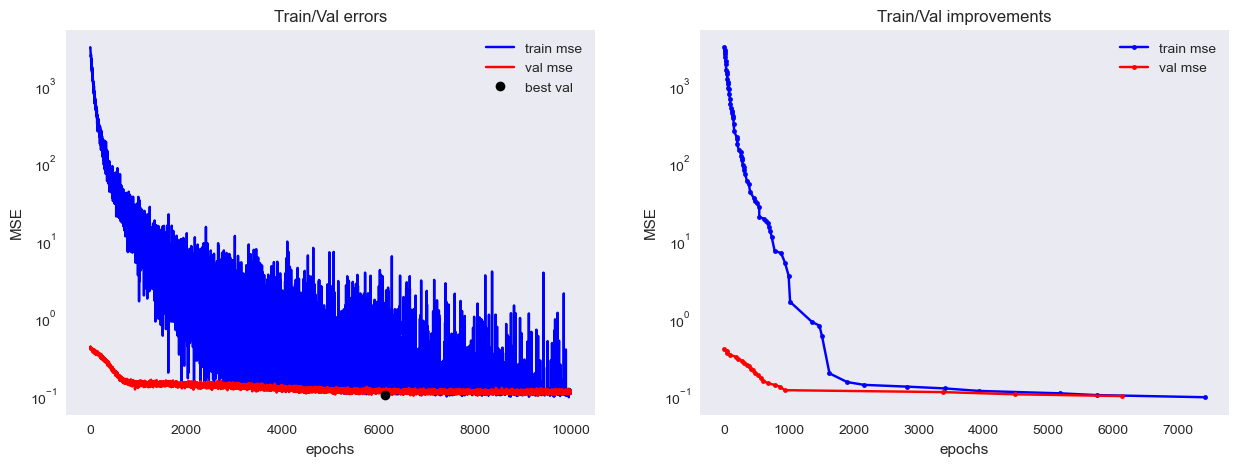

In [16]:
total_train_losses = model.train_loss_list
total_val_losses = model.val_loss_list

plot_loss_convergence(total_train_losses, total_val_losses, rel_save_thresh, model.save_folder)